In [1]:
from mountain import Mountain_one
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(256)

In [3]:
def policy_evaluation(env, policy, gamma=1, eps=1e-4, order='rtl', k=None):
    """
    Evaluate a policy given an environment and a description of it.
    
    Parameters:
        policy: A function that maps a state to an action.
        env: The environment which is an instance of the Mountain class.
        gamma: The discount factor.
        eps: We stop evaluation once our value function change is less than eps for all states.
        order: Order in which to update the states.
        k: Number of sweeps for policy evaluation. If None, evaluation continues until convergence.
    
    Returns:
        State-value function.
    """

    V = np.zeros((31, 100))
    iter = 0
    while k is None or k > 0:
        delta = 0
        states = [(i, j) for i in range(31) for j in range(100)]
        if order == 'rtl':
            states.reverse()

        for state in states:
            v = 0

            action_probabilities = policy(state)

            for action, prob in action_probabilities.items():
                next_state = env.next_state(state, action)
                reward = env.get_reward(state, action)
                v += prob * (reward + gamma * V[next_state])

            delta = max(delta, np.abs(v - V[state]))
            V[state[0], state[1]] = v

        iter += 1

        if delta < eps:
            print("Number of iterations:", iter)
            break

        if k is not None:
            k -= 1

    return V

2. Consider the policy $\pi_{str}$ of heading straight ahead. Use policy evaluation to compute $v_{\pi_{str}}$.

In [4]:
def policy_straight(state):
    return {"forward": 1}

3. (*) Run your policy evaluation ordering the states from left to right (from the top of the mountain to the bottom) 
or from right to left (from the bottom of the mountain to the top). How do the results differ?

In [5]:
env = Mountain_one()
v_straight_left_to_right = policy_evaluation(env, policy_straight, order='ltr')

Number of iterations: 99


In [6]:
v_straight_right_to_left = policy_evaluation(env, policy_straight, order='rtl')

Number of iterations: 2


4. Plot the trajectory followed by the robot according to $\pi_{str}$ from $s_0$ = (15, 0).
5. Plot the trajectory followed by the robot according to $\pi_{str}$ from $s_0$ = (3, 0).

In [7]:
def plot_trajectory(env, policy, initial_state):
    mountain_map = env.get_map()

    fig, ax = plt.subplots()
    ax.imshow(mountain_map, cmap='Greys_r')
    ax.set_title('Mountain Terrain')
    ax.set_xticks(np.arange(0, 101, 20))
    ax.set_yticks(np.arange(0, 32, 10))
    ax.grid(True)

    current_state = initial_state
    trajectory = [current_state]

    while current_state[1] < 99:
        action_probabilities = policy(current_state)
        actions, probabilities = zip(*action_probabilities.items())
        action = np.random.choice(actions, p=probabilities)  # choose action based on probabilities
        next_state = env.next_state(current_state, action)
        trajectory.append(next_state)
        current_state = next_state

    x, y = zip(*[(state[1], state[0]) for state in trajectory])

    ax.plot(x, y, marker='.', linestyle='-', color='slateblue')
    plt.show()

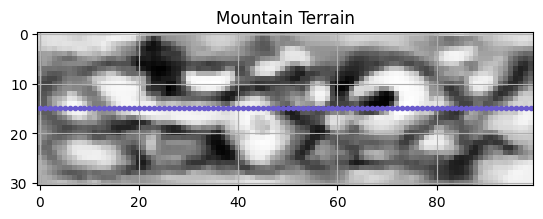

In [8]:
plot_trajectory(env, policy_straight, (15, 0))

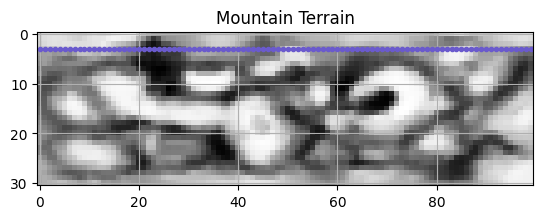

In [9]:
plot_trajectory(env, policy_straight, (3, 0))

6. If the agent were to follow the policy $\pi_{str}$, which starting position in the first column would be optimal?

In [10]:
v_straight_left_to_right[:, 0].argmax()

7

8. Consider now a random policy $\pi_{rnd}$ where each action is taken with uniform probability. Use policy evaluation to compute $v_{\pi_{str}}$.

In [11]:
def policy_random(state):
    actions = ["upforward", "forward", "downforward"]
    action_probabilities = {action: 1 / 3 for action in actions}
    return action_probabilities

In [12]:
v_random = policy_evaluation(env, policy_random)

Number of iterations: 52


9. Plot one sample trajectory that the robot could follow according to $\pi_{rnd}$ from $s_0$ = (15, 0).

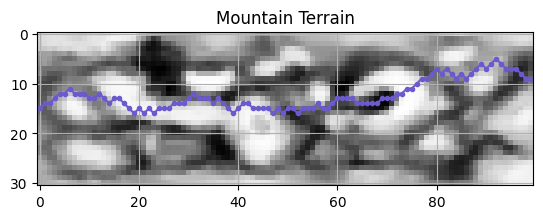

In [13]:
plot_trajectory(env, policy_random, (15, 0))

11. Compare $v_{\pi_{str}}$((15,0)), $v_{\pi_{str}}$((3,0)), $v_{\pi_{rnd}}$((15,0)). If the robot can choose its initial position and its policy, which of the previous 
combination of initial state and policy has the highest value?

In [14]:
v_pi_str_15_0 = policy_evaluation(env, policy_straight)[15, 0]
v_pi_str_3_0 = policy_evaluation(env, policy_straight)[3, 0]
v_pi_rnd_15_0 = policy_evaluation(env, policy_random)[15, 0]

print("State value for initial state (15, 0) under policy π_str:", v_pi_str_15_0)
print("State value for initial state (3, 0) under policy π_str:", v_pi_str_3_0)
print("State value for initial state (15, 0) under policy π_rnd:", v_pi_rnd_15_0)

Number of iterations: 2
Number of iterations: 2
Number of iterations: 52
State value for initial state (15, 0) under policy π_str: -57.80784459
State value for initial state (3, 0) under policy π_str: -52.796080069999995
State value for initial state (15, 0) under policy π_rnd: -51.30835471830138


In [15]:
best_combination = max([("π_str", "(15, 0)", v_pi_str_15_0),
                        ("π_str", "(3, 0)", v_pi_str_3_0),
                        ("π_rnd", "(15, 0)", v_pi_rnd_15_0)], key=lambda x: x[2])

print("The best combination is:", best_combination)

The best combination is: ('π_rnd', '(15, 0)', -51.30835471830138)


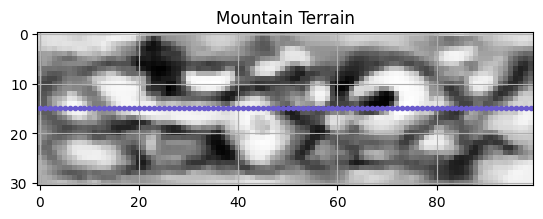

In [16]:
plot_trajectory(env, policy_straight, (15, 0))

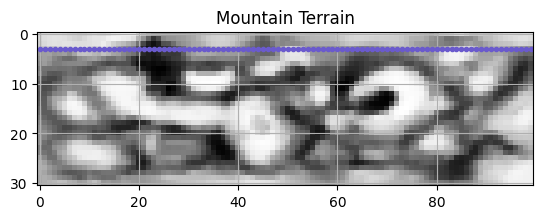

In [17]:
plot_trajectory(env, policy_straight, (3, 0))

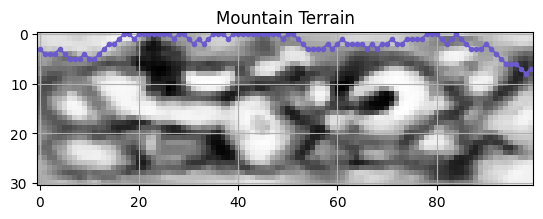

In [18]:
plot_trajectory(env, policy_random, (3, 0))

12. Reconsider the three policy evaluation that you have run. Is the issue of exploration affecting the final result?

Exploration impacts policy evaluation for exploration-based policies like the random policy $\pi_{rnd}$. Such policies may lead to incomplete exploration of the state space, affecting value estimates. In contrast, deterministic policies like the straight policy $\pi_{str}$ provide more consistent but potentially limited exploration. Therefore, exploration quality is important for accurate policy evaluation.

Instead of just evaluating possible policies, the robot now considers trying to learn an optimal policy. Implement an algorithm for policy iteration.

13. Start from $\pi_{rnd}$; find an optimal policy using standard policy iteration where you alternate: 
(i) policy evaluation until the state values are stable (they change less than a ε threshold); and, 
(ii) policy improvement.

In [19]:
def policy_iteration(env, gamma=1, theta=1e-4, k=None):
    policy = {state: np.random.choice(env.actions) for i in range(31) for j in range(100) for state in [(i, j)]}

    # print(policy)

    while True:
        # policy evaluation
        V = policy_evaluation(env, lambda state: {policy[state]: 1}, gamma, theta, k=k)

        # policy improvement
        policy_stable = True
        states = [(i, j) for i in range(31) for j in range(100)]

        for state in states:
            old_action = policy[state]

            # look for the best action by comparing expected returns
            action_returns = {}

            # Bellman optimality equation for the state-value function
            # computes value of taking each action by summing over possible next states and rewards,
            # weighted by their probabilities
            for action in env.actions:
                next_state = env.next_state(state, action)
                reward = env.get_reward(state, action)
                action_value = reward + gamma * V[next_state[0], next_state[1]]  # add weights
                action_returns[action] = action_value

            best_action = max(action_returns, key=action_returns.get)

            # if best action is different from the old action, update the policy
            if old_action != best_action:
                policy_stable = False
                policy[state] = best_action

        if policy_stable:
            break

    # return a policy that for each state returns a dictionary of action probabilities
    final_policy = {state: {action: 1 if action == policy[state] else 0 for action in env.actions}
                    for state in policy}
    return final_policy

In [20]:
env = Mountain_one()
optimal_policy = policy_iteration(env)

Number of iterations: 41
Number of iterations: 41
Number of iterations: 42
Number of iterations: 40
Number of iterations: 33
Number of iterations: 31
Number of iterations: 30
Number of iterations: 30
Number of iterations: 30


14. Plot the optimal trajectory.

In [21]:
def plot_optimal_trajectory(env, policy, initial_state):
    mountain_map = env.get_map()

    fig, ax = plt.subplots()
    ax.imshow(mountain_map, cmap='Greys_r')
    ax.set_title('Optimal Trajectory on Mountain Terrain')
    ax.set_xticks(np.arange(0, 101, 20))
    ax.set_yticks(np.arange(0, 32, 10))
    ax.grid(True)

    current_state = initial_state
    trajectory = [current_state]

    while current_state[1] < 99:
        action_probabilities = policy[current_state]
        action = max(action_probabilities, key=action_probabilities.get)  # action with the highest probability
        next_state = env.next_state(current_state, action)
        trajectory.append(next_state)
        current_state = next_state

    x, y = zip(*[(state[1], state[0]) for state in trajectory])
    ax.plot(x, y, marker='.', linestyle='-', color='slateblue')
    plt.show()

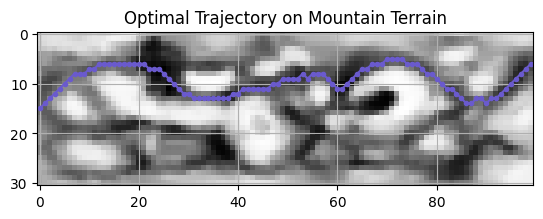

In [22]:
    plot_optimal_trajectory(env, optimal_policy, (15, 0))

15. Always start from $\pi_{rnd}$; find an optimal policy using truncated policy iteration where you alternate: 
(i) $k$ = 3 steps of policy evaluation; and, 
(ii) policy improvement.

16. Plot the optimal trajectory.

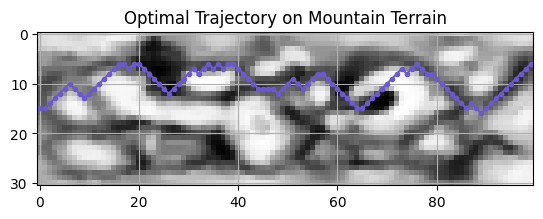

In [23]:
optimal_policy_tpi_3 = policy_iteration(env, k=3)
plot_optimal_trajectory(env, optimal_policy_tpi_3, (15, 0))

17. Start at $s_0$ = (15,0) and $\pi_{rnd}$; find an optimal policy using value iteration. Implement value iteration both as a form of $k$ = 1 
truncated policy iteration and as a direct implementation of the Bellman optimality equation.

18. Plot the optimal trajectory.

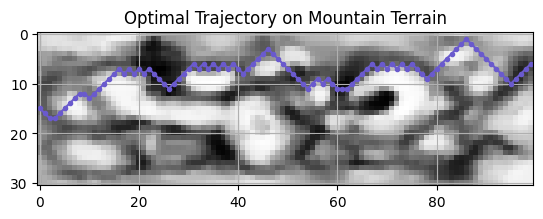

In [24]:
optimal_policy_tpi_1 = policy_iteration(env, k=1)
plot_optimal_trajectory(env, optimal_policy_tpi_1, (15, 0))